# Script pour le calcul de fermeture d'une boucle de nivellement
+ attention le script utilise la bibliothèque OSGEO pas toujours évidente à installer

(5, 7)
[[  0.      0.      0.      1.213 351.      9.8     1.   ]
 [  0.946 196.     15.      1.393 354.7    13.1     2.   ]
 [  0.829 150.     14.45    0.727 168.     13.7     3.   ]
 [  1.29  331.     15.1     1.327 210.1    13.3     2.   ]
 [  1.596 357.     12.05    0.      0.      0.      1.   ]]
fermeture est-ouest in meters  (x coordinates):
1.1563
fermeture nord-sud in meters (y coordinates):
-0.5385
fermeture verticale in millimeters (z coordinates):
-1.0000


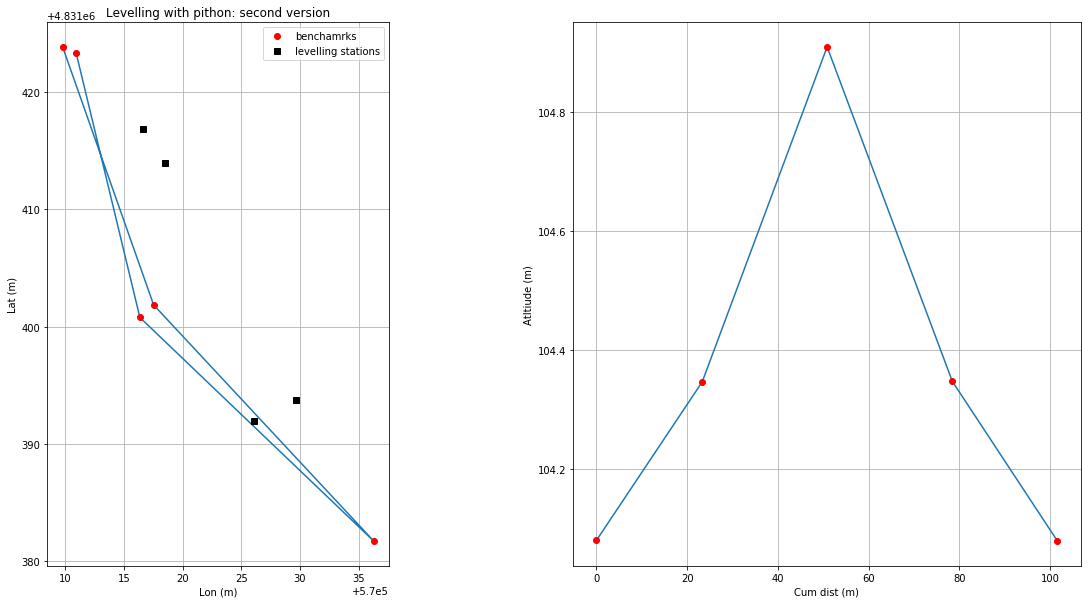

In [4]:
# Automatic levelling data processing and plot
# m1 2018 geodesy champollion 
# v 0.2: improvement of portability by P. Vernant
import osgeo.ogr as ogr
import osgeo.osr as osr
from pylab import *

# raw data importation
# angles in grades!!!!!
# distances and height in meter

#conversion grad in rad
g2r=pi/200

#conversion deg in rad
d2r=pi/180

#real coordinates
Xref=0
Yref=0
Zref=0
Xref=570009.758 
Yref=4831423.853
Zref=104.079

data_nivel = loadtxt('nivel.dat')
type(data_nivel)
data_nivel
H1=data_nivel[:,0]
A1=data_nivel[:,1]
D1=data_nivel[:,2]
H2=data_nivel[:,3]
A2=data_nivel[:,4]
D2=data_nivel[:,5]
pt=rint(data_nivel[:,6])
nb_vise = data_nivel.shape[0]
print(data_nivel.shape)
print(data_nivel)
# initialization of point coordinates
X = zeros(nb_vise)
Y = zeros(nb_vise)
Z = zeros(nb_vise)

# initialisation of leveling stations
ptXs = zeros(nb_vise-1)
Xs = zeros(nb_vise-1)
Ys = zeros(nb_vise-1)
Zs = zeros(nb_vise-1)

#loop over the station
#je ne sais pas faire une boucle for alors un while...., CC
i = 0
#ici the real geographical coordinates can be used
X[i]=Xref
Y[i]=Yref
Z[i]=Zref

while i < nb_vise-1:
#backward measurement -> station coordinates
   Xs[i]=X[i]+D2[i]*sin(pi+A2[i]*g2r)
   Ys[i]=Y[i]+D2[i]*cos(pi+A2[i]*g2r)
   Zs[i]=Z[i]+H2[i]
   ptXs[i] = i+1
   i += 1
#forward station -> point coordinates
   X[i]=Xs[i-1]+D1[i]*sin(A1[i]*g2r)
   Y[i]=Ys[i-1]+D1[i]*cos(A1[i]*g2r)
   Z[i]=Zs[i-1]-H1[i]
  

#fermeture de boucle
#horizontal
print('fermeture est-ouest in meters  (x coordinates):')
print('%.04f'% (X[nb_vise-1]-X[0]))
print('fermeture nord-sud in meters (y coordinates):')
print('%.04f'% (Y[nb_vise-1]-Y[0]))
#vertical
print('fermeture verticale in millimeters (z coordinates):')
print('%.04f'% ((Z[nb_vise-1]-Z[0])*1000.0))


#output
file=open('nivel_sta.txt', 'w')
print('point, X, Y, Z , type ', file=file)
savetxt(file,transpose([pt,X,Y,Z]),delimiter=' ', fmt='%4s  %.04f  %.04f  %.04f   benchmark')
savetxt(file,transpose([ptXs,Xs,Ys,Zs]),delimiter=' ', fmt='%4s  %.04f  %.04f  %.04f   levelling_station')
file.close()

#distance
i=0
dh = zeros(nb_vise-1)
dz = zeros(nb_vise-1)
cum_dh = zeros(nb_vise)
cum_dh[0]=0
while i < nb_vise-1:
    dh[i]=sqrt( (X[i+1]-X[i])**2 + (Y[i+1]-Y[i])**2 )
    dz[i]=sqrt( (Z[i+1]-Z[i])**2 )
    cum_dh[i+1]=cum_dh[i]+dh[i]
    i += 1
file=open('nivel_res.txt', 'w')
print('# dh, dz distances (m) ', file=file)
savetxt(file,(dh,dz),delimiter=' ', fmt='%0+.04f')
print('', file=file)
file.close()

#plot
figure(1, figsize=(20,10))
clf()

subplot(121)
title('Levelling with pithon: second version')
plot(X,Y)
plot(X,Y,'ro',label='benchamrks')
plot(Xs,Ys,'ks',label='levelling stations')
xlabel('Lon (m)')
ylabel('Lat (m)')
grid(True)
axis('scaled')
legend(loc='upper right')



subplot(122)
plot(cum_dh,Z)
plot(cum_dh,Z,'ro')
xlabel('Cum dist (m)')
ylabel('Atltiude (m)')
grid(True)
show()








#Last step: ouput for QGIS
# set up the shapefile driver
driver = ogr.GetDriverByName("ESRI Shapefile")

# create the data source
data_source = driver.CreateDataSource("nivel.shp")

# create the spatial reference, WGS84
srs = osr.SpatialReference()
#proj UTM31N / WGS84
srs.ImportFromEPSG(32631)


# create the layer
layer = data_source.CreateLayer("meas", srs, ogr.wkbPoint)

# Add the fields we're interested in
layer.CreateField(ogr.FieldDefn("Name", ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn("Elevation", ogr.OFTReal))
field_name = ogr.FieldDefn("Type", ogr.OFTString)
field_name.SetWidth(24)
layer.CreateField(field_name)

# Process the text file and add the attributes and features to the shapefile
i = 0
while i < nb_vise:
  # POINTS
  # create the feature 
  feature = ogr.Feature(layer.GetLayerDefn())
  # Set the attributes using the values from the delimited text file
  feature.SetField("Name", int(pt[i]))
  feature.SetField("Elevation", Z[i])
  feature.SetField("Type", 'points')

  # create the WKT for the feature using Python string formatting
  wkt = "POINT(%f %f)" %  (X[i] , Y[i])

  # Create the point from the Well Known Txt
  point = ogr.CreateGeometryFromWkt(wkt)

  # Set the feature geometry using the point
  feature.SetGeometry(point)
  # Create the feature in the layer (shapefile)
  layer.CreateFeature(feature)
  # Dereference the feature
  feature = None    
  i += 1

i = 0
while i < nb_vise-1:
  # STATIONS
  # create the feature 
  feature = ogr.Feature(layer.GetLayerDefn())
  # Set the attributes using the values from the delimited text file
  feature.SetField("Name", int(ptXs[i]))
  feature.SetField("Elevation", Zs[i])
  feature.SetField("Type", 'stations')

  # create the WKT for the feature using Python string formatting
  wkt = "POINT(%f %f)" %  (Xs[i] , Ys[i])

  # Create the point from the Well Known Txt
  point = ogr.CreateGeometryFromWkt(wkt)

  # Set the feature geometry using the point
  feature.SetGeometry(point)
  # Create the feature in the layer (shapefile)
  layer.CreateFeature(feature)
  # Dereference the feature
  feature = None    
  i += 1

# Save and close the data source
data_source = None

